In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [2]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution, plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [3]:
A = np.random.uniform(size = (100, 100))
x = np.random.uniform(size = (A.shape[1], ))

In [4]:
def model_func(x):
    return np.dot(A, x)

In [5]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [6]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 100,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }

In [7]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)

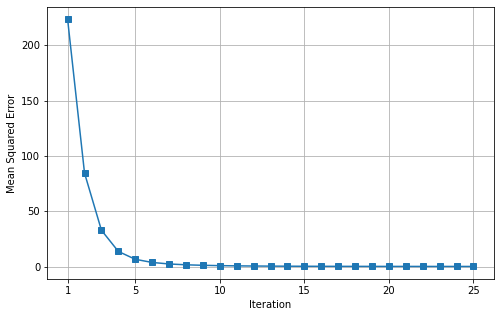

In [8]:
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1)

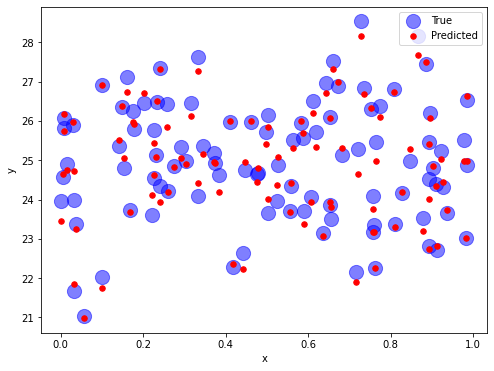

In [9]:
plot_IP_true_false(setting_dict,
                   final_params)

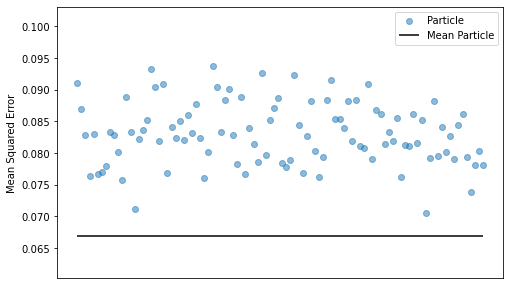

In [10]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

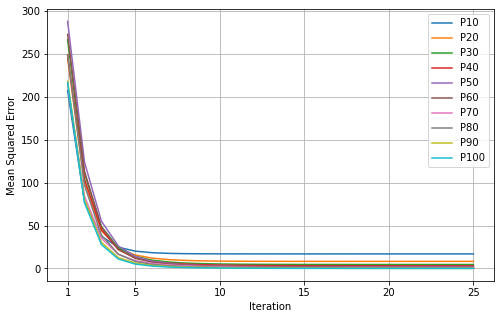

In [11]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1)

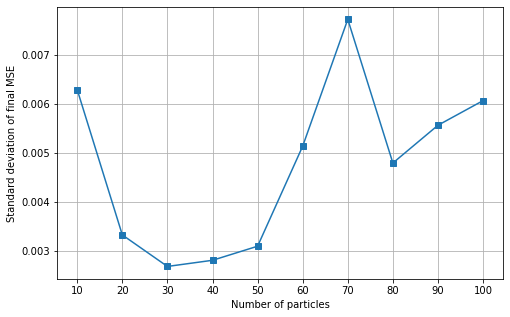

In [12]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_particle_std(setting_dict,
                     particle_list)

## Modell:
$Ax=y + \eta$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch), $\eta\sim\mathscr{N}(0,\Gamma)$.

$x$ wird gesucht.

In [13]:
A = np.random.uniform(size = (100, 100))
x = np.random.uniform(size = (A.shape[1], ))

In [14]:
def model_func(x):
    return np.dot(A, x)

In [15]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [16]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 100,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }

In [17]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)

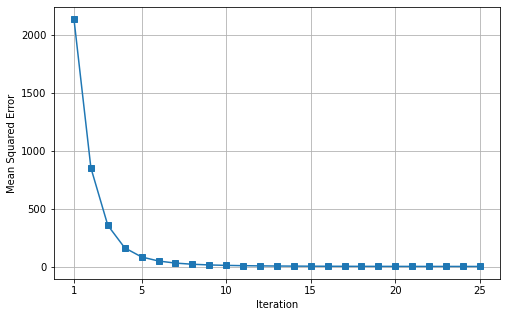

In [18]:
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1)

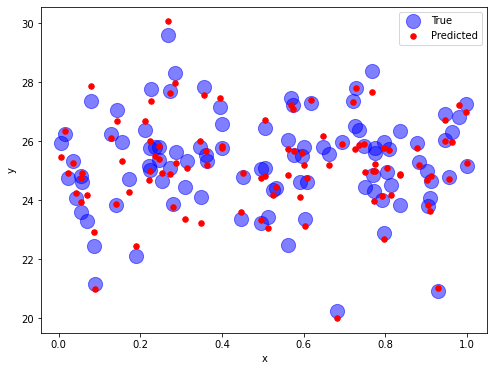

In [19]:
plot_IP_true_false(setting_dict,
                   final_params)

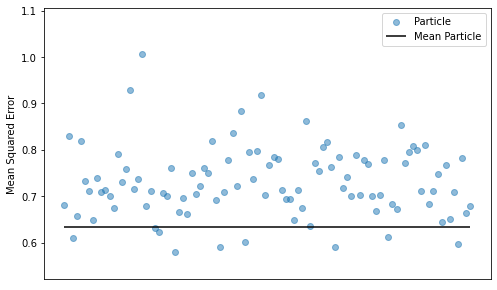

In [20]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

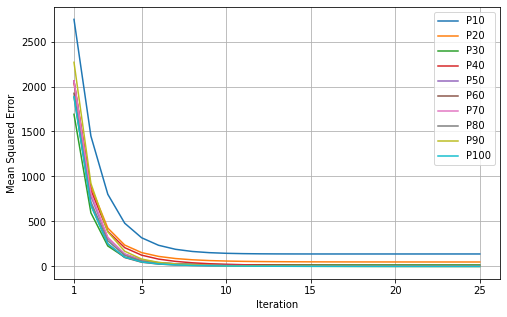

In [21]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1)

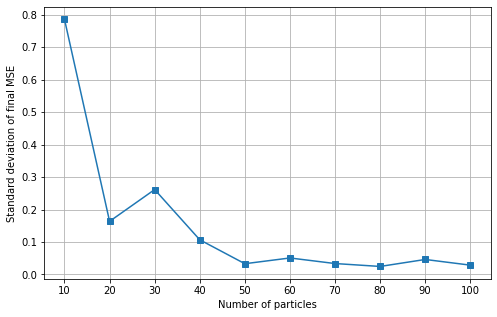

In [22]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_particle_std(setting_dict,
                     particle_list)

# Nichtlineares Modell

## Modell:
$sin(x)=y$

$x$ wird gesucht.

In [23]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [24]:
def model_func(x):
    return np.sin(x)

In [25]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [26]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 100,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }

In [27]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)

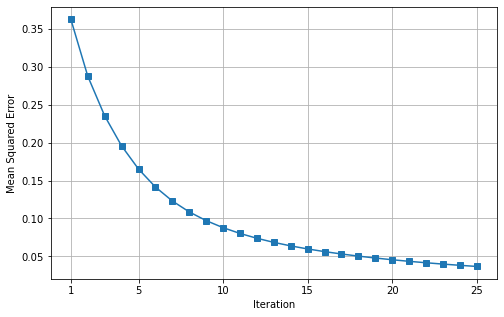

In [28]:
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1)

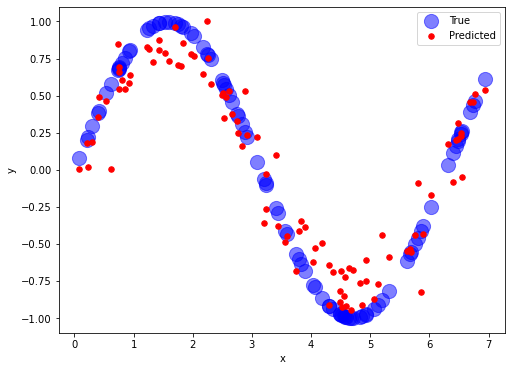

In [29]:
plot_IP_true_false(setting_dict,
                   final_params)

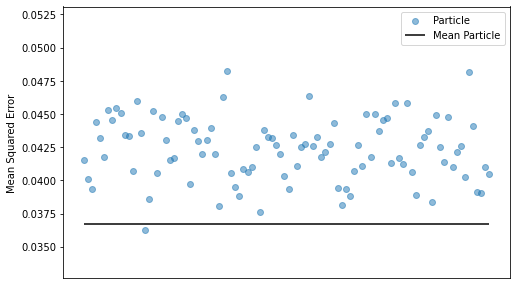

In [30]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

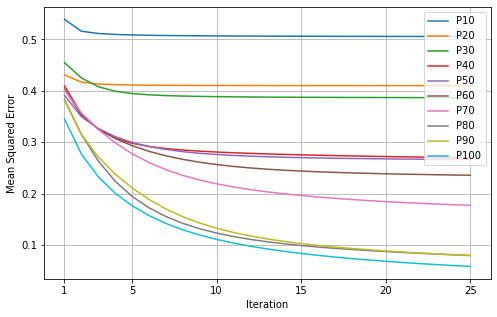

In [31]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1)

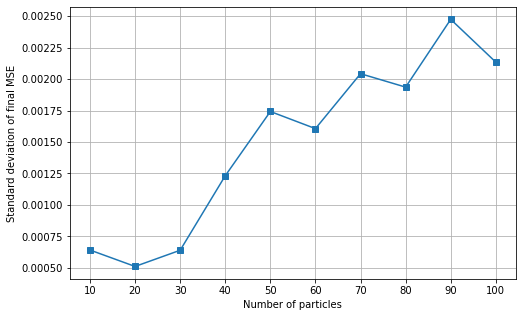

In [32]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_particle_std(setting_dict,
                     particle_list)

## Modell:
$\sin(x)=y + \eta$ mit $\eta\sim\mathscr{N}(0,\Gamma)$

$x$ wird gesucht.

In [33]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [34]:
def model_func(x):
    return np.sin(x)

In [35]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [36]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 100,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }

In [37]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)

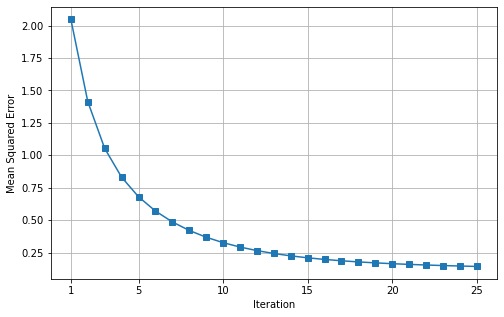

In [38]:
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1)

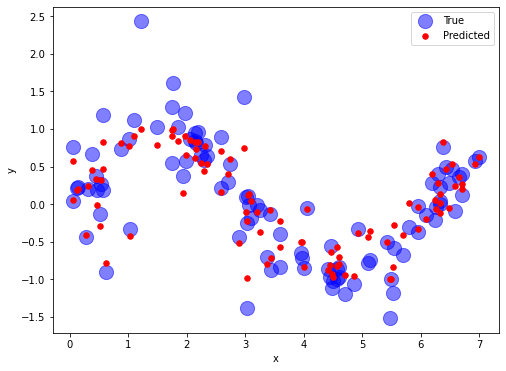

In [39]:
plot_IP_true_false(setting_dict,
                   final_params)

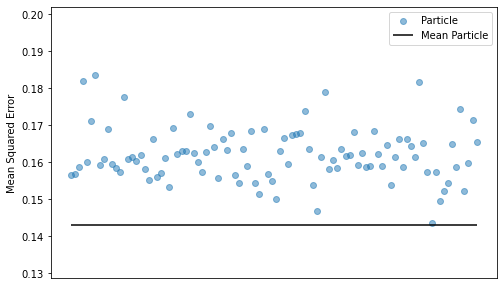

In [40]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

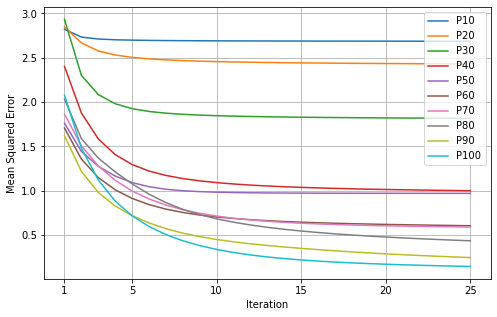

In [41]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1)

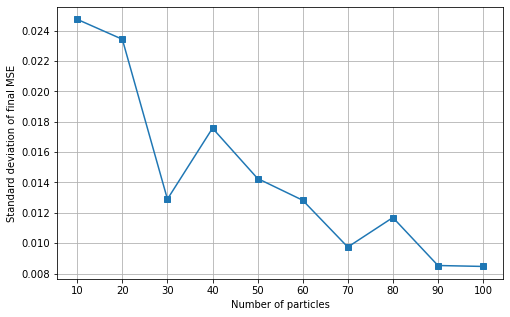

In [42]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_IP_particle_std(setting_dict,
                     particle_list)